In [1]:
import tomosipo as ts
import numpy as np
import pickle
import mrcfile
import numpy as np
from sklearn.manifold import TSNE
from numpy import reshape
import seaborn as sns
import pandas as pd  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score
import os
import matplotlib.pyplot as plt
import astra
from tomosipo.geometry.parallel_vec import *
from scipy.ndimage import zoom
from models import *
%matplotlib inline


In [2]:
data_name = '70s_2class_0303'
os.makedirs(f'./data/{data_name}', exist_ok = True)

with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)
          
with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)
          
with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)
          
with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)

indexs [1 0 0 1 0 1 1 1 0 0]


In [3]:
print(angles2[:10])

[[2.40942756 1.13249336 2.89793666]
 [5.31844339 1.0869395  2.20724338]
 [3.20953919 2.25659501 0.53914008]
 [0.56004307 0.74672586 6.0874194 ]
 [0.87917772 1.27133902 0.91340428]
 [0.59394877 0.14236928 6.23363297]
 [3.54547493 1.39268731 0.35889984]
 [3.3839112  0.93995388 1.54736336]
 [0.20487516 0.17167568 4.80926139]
 [2.76723454 1.31594475 2.98388959]]


In [4]:
print(new_projection.shape)
ProjSize = 34
Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)
pg = ts.from_astra(Proj_geom)
Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)
Vol_geom = astra.create_vol_geom(34, 34, 34)
vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
A = ts.operator(vg, pg)

print(pg.ray_dir[:20])
"""
print(pg.det_v[:5])
print(pg.det_u[:5])
print(Orientation_Vectors[:5])
print(pg[:5])
"""


(10000, 34, 34)
[[ 0.42440346  0.60529203 -0.67342651]
 [ 0.46519672 -0.72755361  0.50423978]
 [-0.63329132 -0.05254429 -0.77212771]
 [ 0.73391673  0.36082741  0.57547356]
 [ 0.29500171  0.73593763  0.60940118]
 [ 0.9898826   0.07940636  0.11758855]
 [ 0.17716882 -0.38677428 -0.90499551]
 [ 0.58982527 -0.19377033 -0.78393827]
 [ 0.98529989  0.03475524  0.16726089]
 [ 0.25210179  0.35386413 -0.90068022]
 [ 0.88128768 -0.02700698 -0.47180785]
 [ 0.20717225 -0.80685147  0.55323626]
 [ 0.51039191 -0.74530063  0.42898377]
 [ 0.51002096 -0.11863498 -0.85194152]
 [ 0.99463322  0.09812827 -0.03279647]
 [ 0.3454954  -0.8366411   0.42504657]
 [ 0.53109402 -0.08900614 -0.8426251 ]
 [ 0.85735067  0.43128908  0.28096185]
 [ 0.26118639 -0.85677347  0.44465817]
 [ 0.37975084 -0.86460541  0.32900879]]


'\nprint(pg.det_v[:5])\nprint(pg.det_u[:5])\nprint(Orientation_Vectors[:5])\nprint(pg[:5])\n'

(10000, 34, 34)


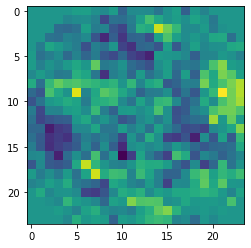

In [5]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
#plt.imshow(mask)
#plt.show()
snr = 10
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)
    mask = create_circular_mask(34, 34, radius = 14)

new_projection = new_projection * mask
print(new_projection.shape)
new_projection = new_projection[:,5:29,5:29]
plt.imshow(new_projection[0])
plt.show()

indexs [1 0 0 1 0 1 1 1 0 0]
(10000, 34, 34)


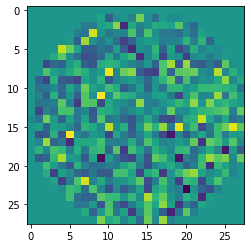

(10000, 28, 28)


/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/models.py:77: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272097173/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  self.U1.data = torch.qr(self.U1.data)[0]
/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1161.844377040863 sec
0 batch 1 iteration
generated


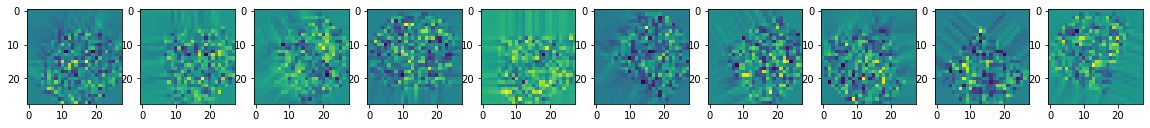

real


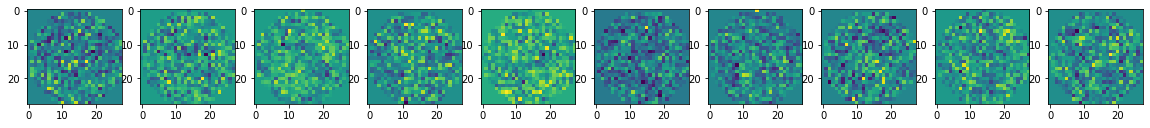

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.036s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1.015002
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.821404
[t-SNE] KL divergence after 1000 iterations: 0.633462
self.All_U_kron_shape torch.Size([21952, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


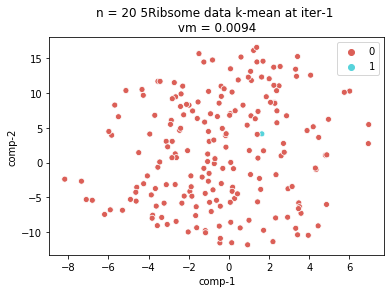

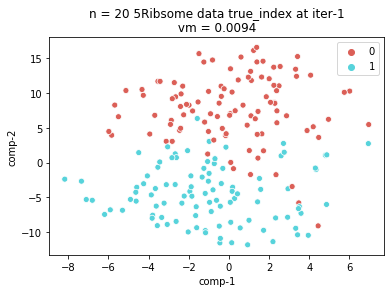

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


In [ ]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.8
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
    
new_projection = new_projection * mask
print(new_projection.shape)
new_projection = new_projection[:,5:29,5:29]
plt.imshow(new_projection[0])
plt.show()
n = 20
b = 200
niter = 10
pca_n = 5
Images = new_projection#[:5000]
print(Images.shape)
exp_name = f'20220318_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 28, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(28, 28, 28)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

indexs [1 0 0 1 0 1 1 1 0 0]
(10000, 34, 34)


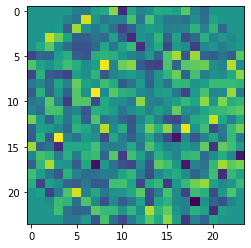

(10000, 24, 24)


/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1111.0289838314056 sec
0 batch 1 iteration
generated


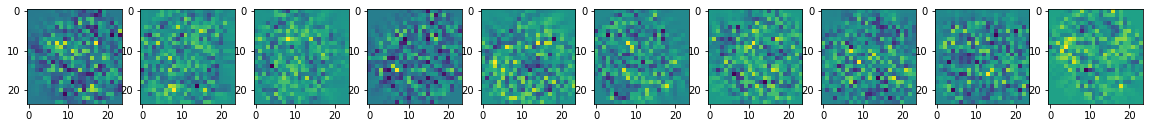

real


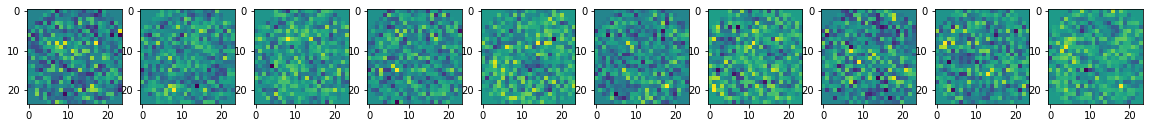

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.042s...
[t-SNE] Computed neighbors for 200 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 2.694559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.855431
[t-SNE] KL divergence after 850 iterations: 0.549787
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


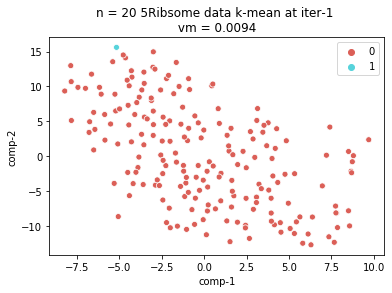

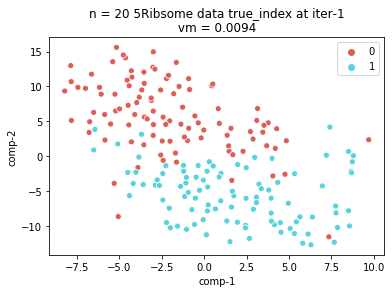

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1042.9936780929565 sec
0 batch 2 iteration
generated


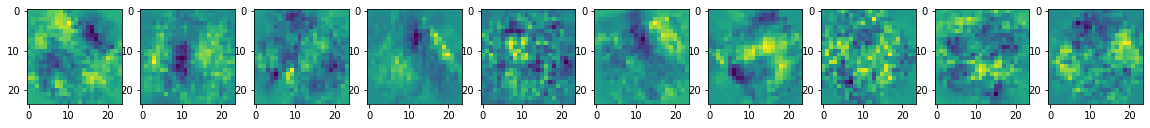

real


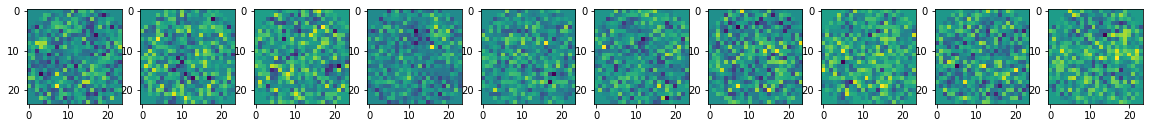

1039.7570304870605 sec
0 batch 3 iteration
generated


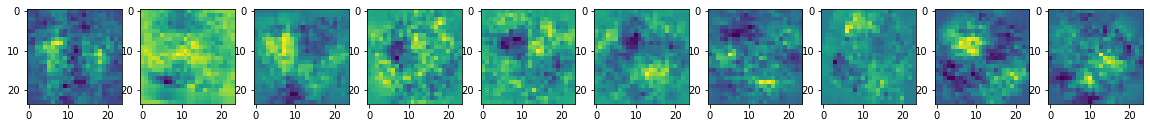

real


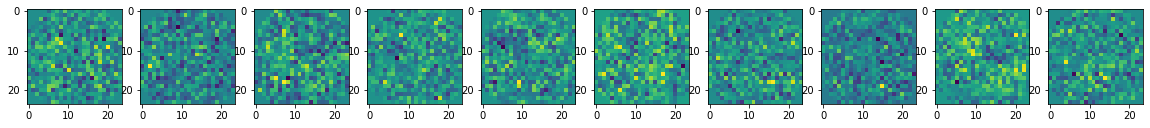

1089.7246580123901 sec
0 batch 4 iteration
generated


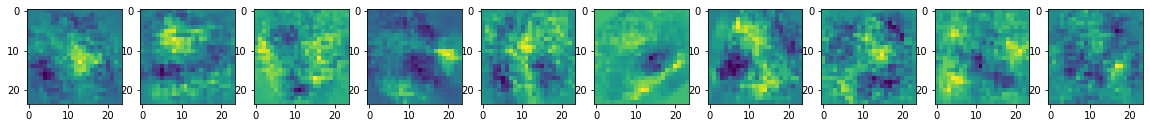

real


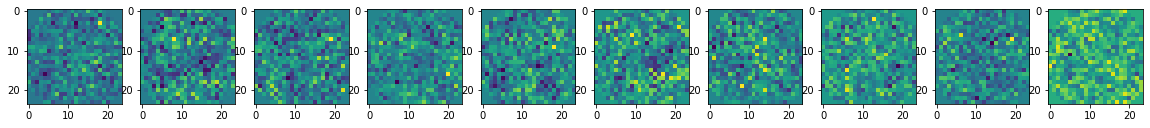

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.045865
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.379692
[t-SNE] KL divergence after 1000 iterations: 0.599570
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


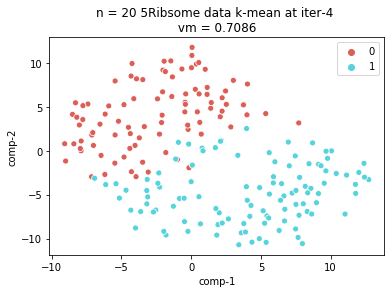

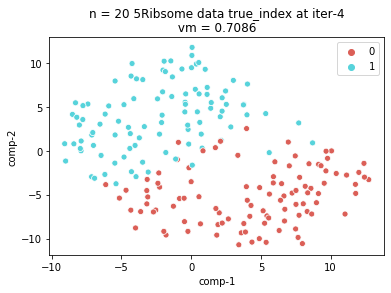

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1051.5606093406677 sec
0 batch 5 iteration
generated


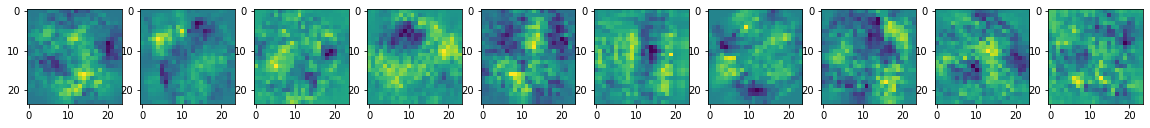

real


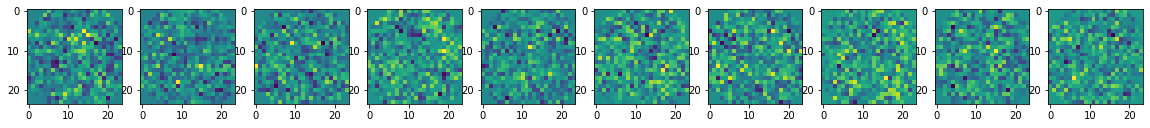

1131.4867758750916 sec
0 batch 6 iteration
generated


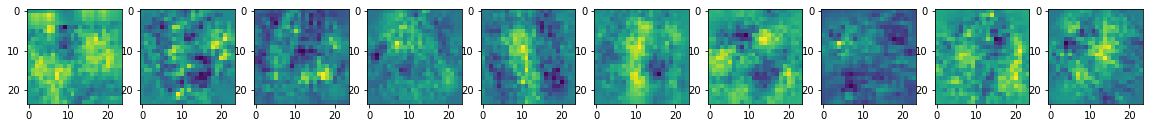

real


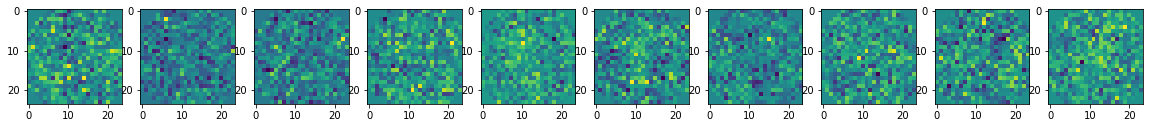

1053.5004587173462 sec
0 batch 7 iteration
generated


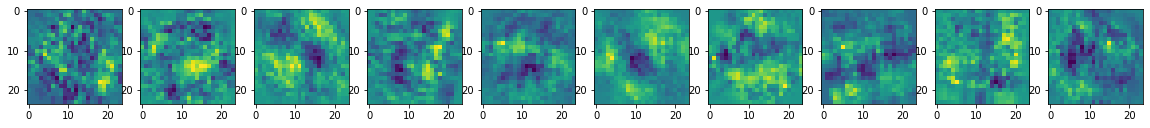

real


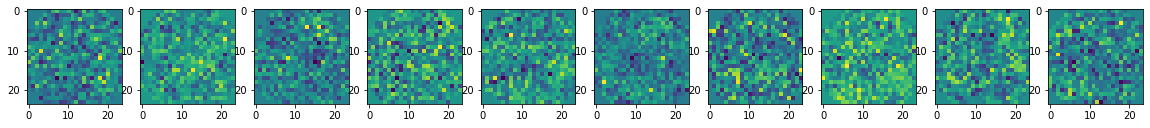

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.039041
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.962170
[t-SNE] KL divergence after 1000 iterations: 0.571179
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


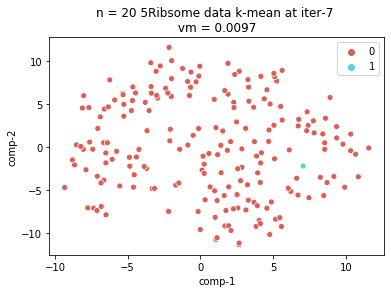

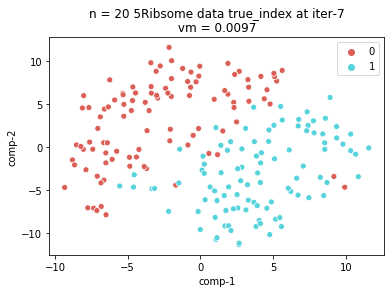

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1059.636813879013 sec
0 batch 8 iteration
generated


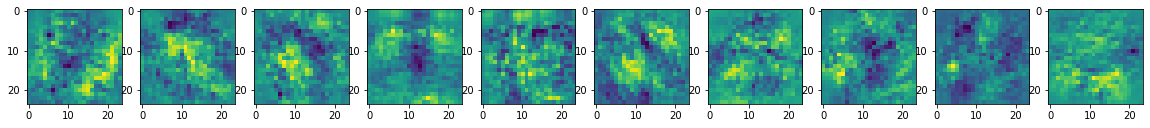

real


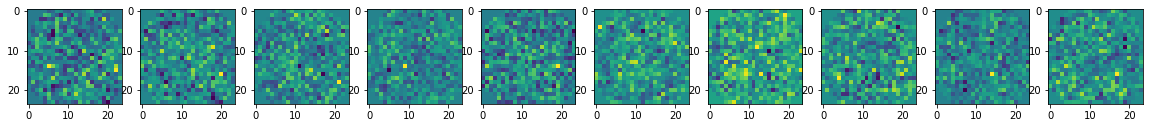

1065.900072813034 sec
0 batch 9 iteration
generated


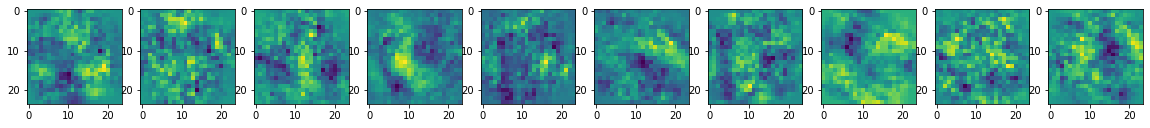

real


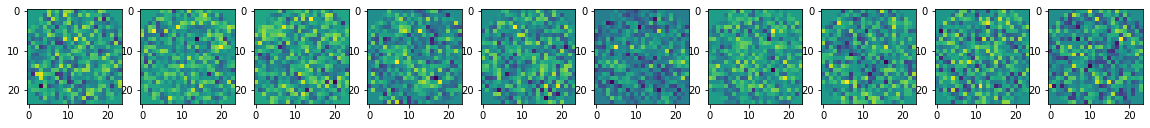

1046.4068267345428 sec
0 batch 10 iteration
generated


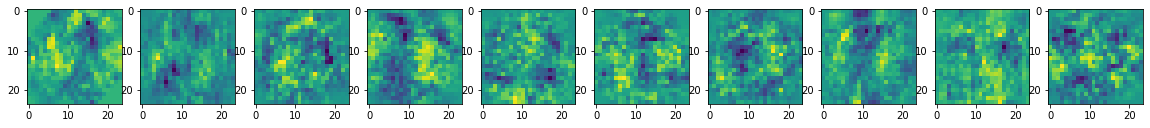

real


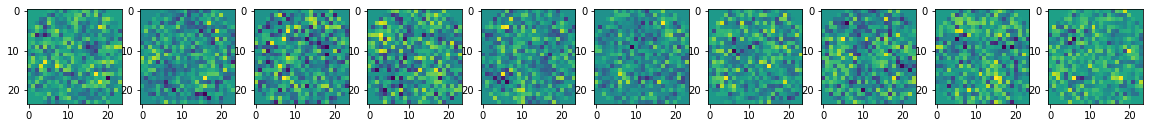

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.032346
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.806160
[t-SNE] KL divergence after 1000 iterations: 0.724526
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


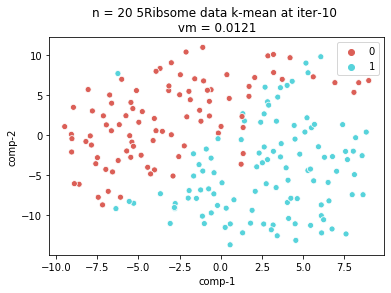

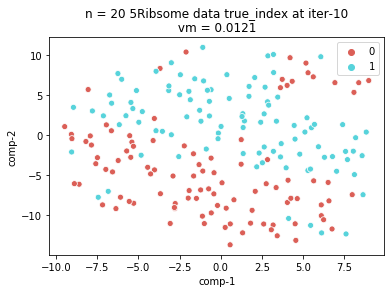

the 0 th iter, ratio = 0.1
output_collection 0-th batch


/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.001s...
[t-SNE] Computed neighbors for 200 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.032346
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.601265
[t-SNE] KL divergence after 1000 iterations: 0.740587
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


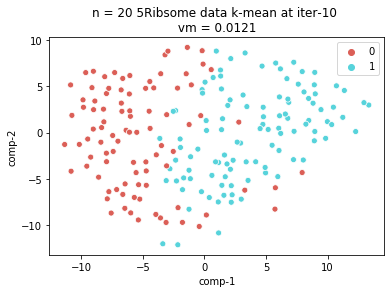

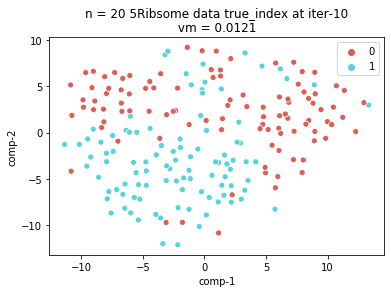

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1029.9575290679932 sec
1 batch 1 iteration
generated


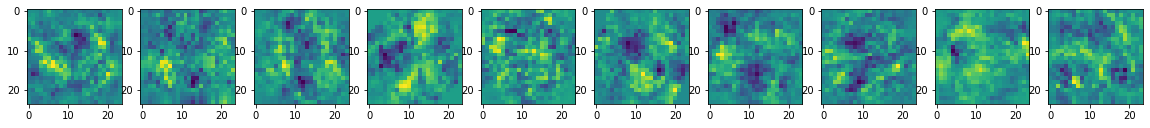

real


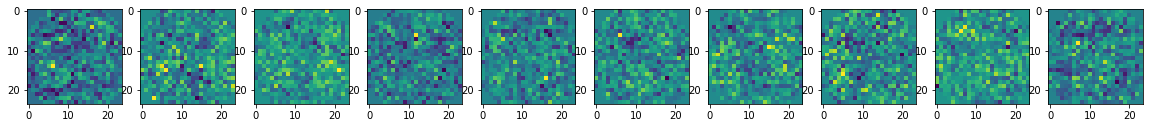

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.002s...
[t-SNE] Computed neighbors for 200 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.031281
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.834423
[t-SNE] KL divergence after 1000 iterations: 0.860654
self.All_U_kron_shape torch.Size([13824, 8000])
self.PCs.shape torch.Size([8000, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


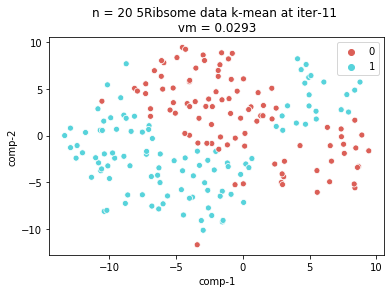

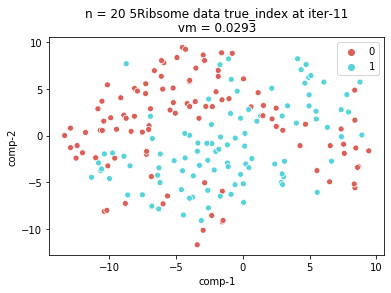

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1005.4879429340363 sec
1 batch 2 iteration
generated


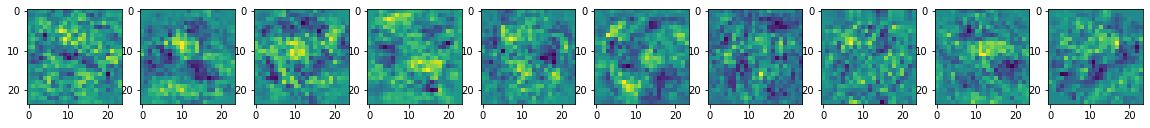

real


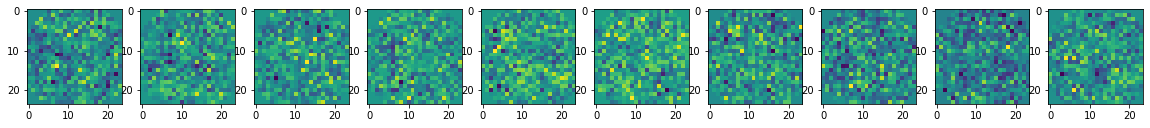

1008.4699468612671 sec
1 batch 3 iteration
generated


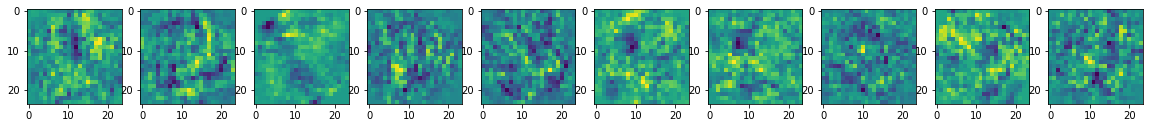

real


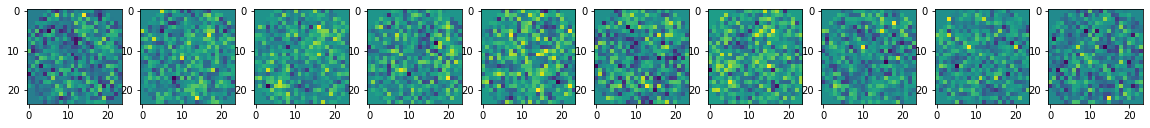

KeyboardInterrupt: 

In [12]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.2
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
    
new_projection = new_projection * mask
print(new_projection.shape)
new_projection = new_projection[:,5:29,5:29]
plt.imshow(new_projection[0])
plt.show()
n = 20
b = 200
niter = 10
pca_n = 5
Images = new_projection#[:5000]
print(Images.shape)
exp_name = f'20220318_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 24, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(24, 24, 24)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
MP3.fit(0.1, True)

indexs [1 0 0 1 0 1 1 1 0 0]
(10000, 34, 34)


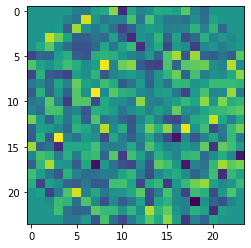

(10000, 24, 24)


/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/models.py:77: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272097173/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1937.)
  self.U1.data = torch.qr(self.U1.data)[0]
/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1.913093090057373 sec
0 batch 1 iteration
generated


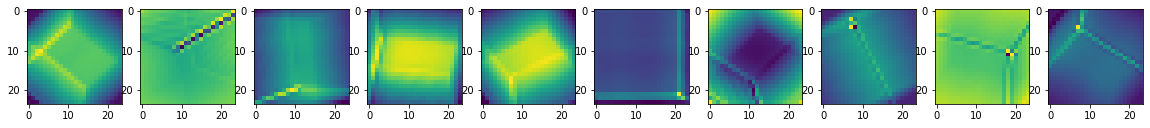

real


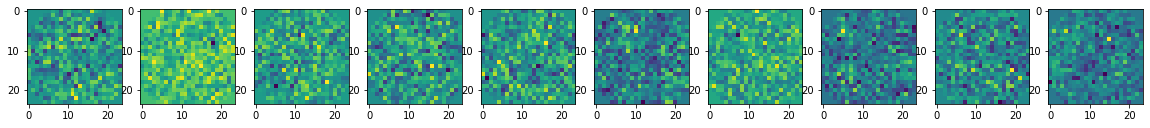

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.009988
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.851501
[t-SNE] KL divergence after 1000 iterations: 0.155680
self.All_U_kron_shape torch.Size([13824, 8])
self.PCs.shape torch.Size([8, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


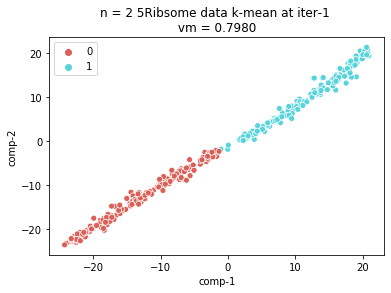

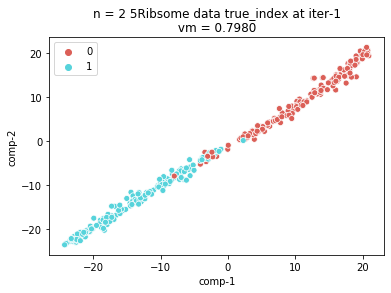

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1.7088074684143066 sec
0 batch 2 iteration
generated


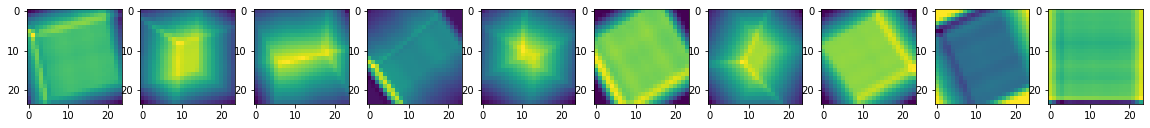

real


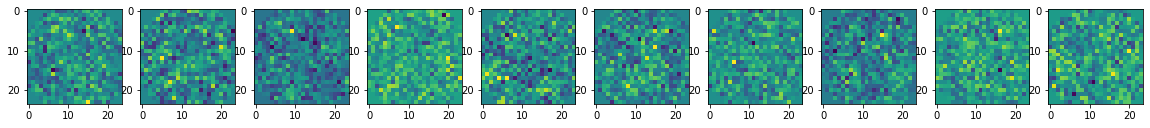

1.680882453918457 sec
0 batch 3 iteration
generated


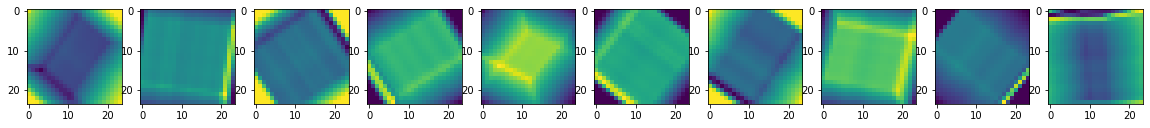

real


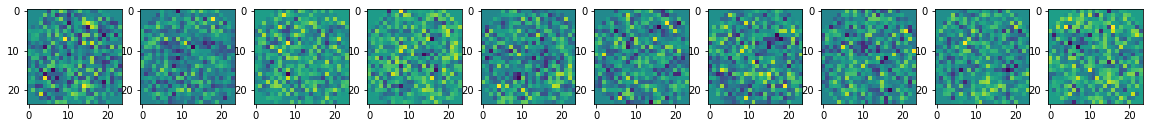

1.8391354084014893 sec
0 batch 4 iteration
generated


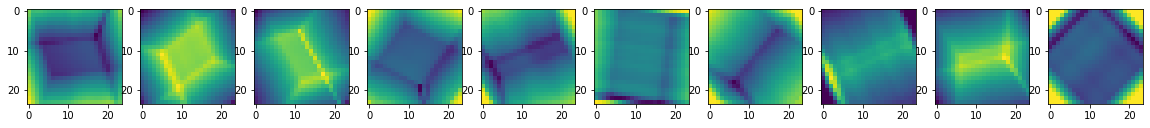

real


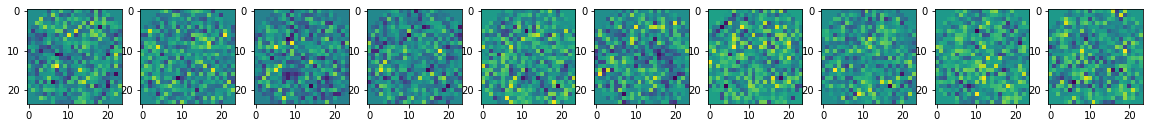

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.008321
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.961864
[t-SNE] KL divergence after 1000 iterations: 0.156697
self.All_U_kron_shape torch.Size([13824, 8])
self.PCs.shape torch.Size([8, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


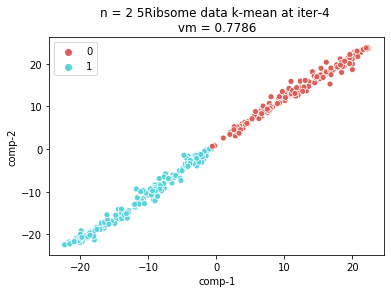

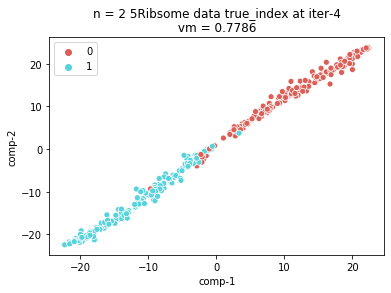

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


1.513195276260376 sec
0 batch 5 iteration
generated


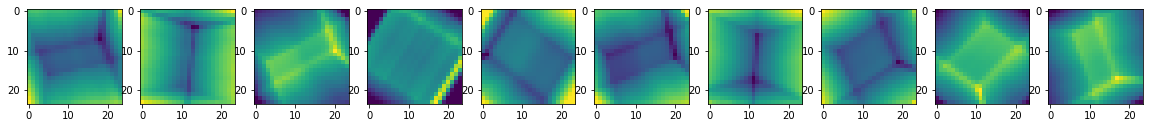

real


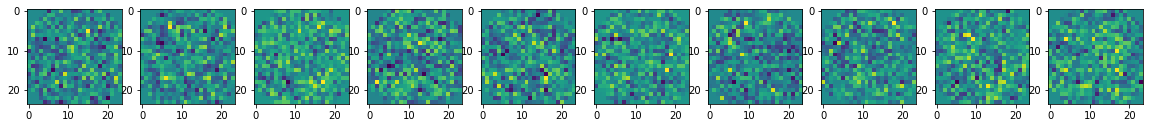

1.715219259262085 sec
0 batch 6 iteration
generated


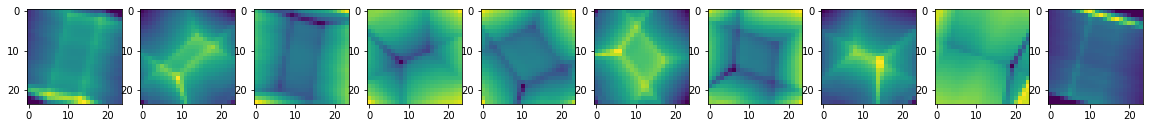

real


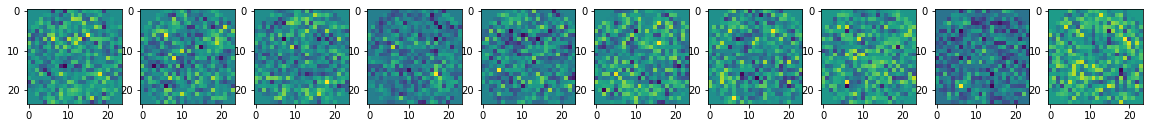

1.7339389324188232 sec
0 batch 7 iteration
generated


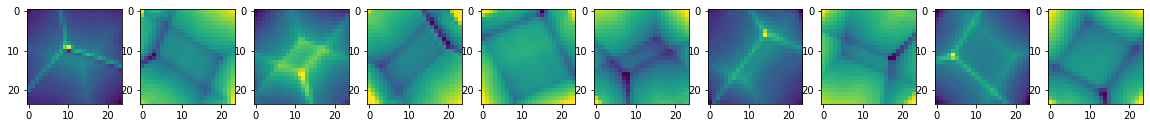

real


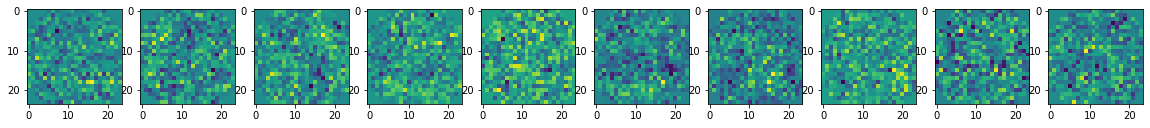

output_collection 0-th batch
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.006805
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.802353
[t-SNE] KL divergence after 1000 iterations: 0.162152
self.All_U_kron_shape torch.Size([13824, 8])
self.PCs.shape torch.Size([8, 5])
self.ori_var_each 0.0
self.projected_var_each 0.0


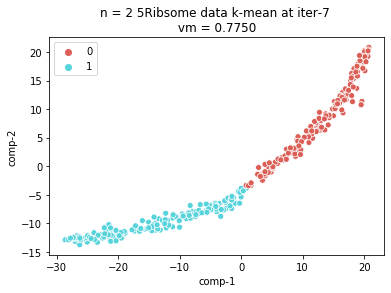

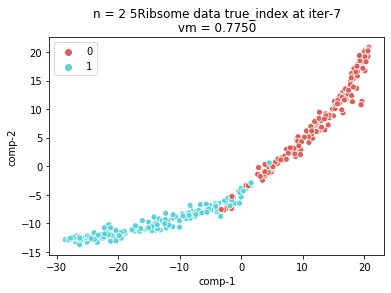

/home/users/lewis841214/Desktop/1project/CryoEMCode/GPU_CryoEM/tomosipo_structureed/tomosipo/links/torch.py:64: UserWarning: The parameter initial_value should be contiguous. It has been automatically made contiguous. Use `ts.link(x.contiguous())' to inhibit this warning. 
  f"The parameter initial_value should be contiguous. "


KeyboardInterrupt: 

In [20]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.2
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
    
new_projection = new_projection * mask
print(new_projection.shape)
new_projection = new_projection[:,5:29,5:29]
plt.imshow(new_projection[0])
plt.show()
n = 20
b = 300
niter = 10
pca_n = 5
Images = new_projection#[:5000]
print(Images.shape)
exp_name = f'20220318_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 24, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(24, 24, 24)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 5
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
n = 5
b = 400
niter = 10
pca_n = 2
Images = new_projection[:5000]
print(Images.shape)
exp_name = f'20220303_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 34, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(34, 34, 34)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.4
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
n = 10
b = 400
niter = 10
pca_n = 2
Images = new_projection[:5000]
print(Images.shape)
exp_name = f'20220303_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 34, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(34, 34, 34)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.2
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
n = 15
b = 400
niter = 10
pca_n = 2
Images = new_projection[:5000]
print(Images.shape)
exp_name = f'20220303_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 34, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(34, 34, 34)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
#snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
snr = 0.1
data_name = f'70s_2class_0304+{snr}'
with open(f'./data/{data_name}/images.pkl', 'rb') as f:
    new_projection = pickle.load( f)

with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
    angles2 = pickle.load( f)

with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
    Orientation_Vectors = pickle.load(f)

with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
    indexs = pickle.load(f)
print('indexs',indexs[:10])     
with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
    mean_subtracted_strcut = pickle.load(f)
n = 10
b = 400
niter = 10
pca_n = 2
Images = new_projection[:5000]
print(Images.shape)
exp_name = f'20220303_{data_name}_EM_2SDR_n_{n}'
ProjSize, num_image, n_component , num_iter = 34, Images.shape[0], n, niter
batch_size = b
Vol_geom = astra.create_vol_geom(34, 34, 34)
#Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

vg = ts.from_astra(Vol_geom)
pg = ts.from_astra(Proj_geom)
op = ts.operator(vg, pg)
MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
MP3.fit(0.1, True)

In [ ]:
snr_list = [10, 5, 1, 0.8, 0.6, 0.4, 0.2, 0.1]
for snr in snr_list:
#snr = 0.1
    data_name = f'70s_2class_0304+{snr}'
    with open(f'./data/{data_name}/images.pkl', 'rb') as f:
        new_projection = pickle.load( f)

    with open(f'./data/{data_name}/angles.pkl', 'rb') as f:
        angles2 = pickle.load( f)

    with open(f'./data/{data_name}/orientation_matrix.pkl', 'rb') as f:
        Orientation_Vectors = pickle.load(f)

    with open(f'./data/{data_name}/indexs.pkl', 'rb') as f:
        indexs = pickle.load(f)
    print('indexs',indexs[:10])     
    with open(f'./data/{data_name}/mean_subtracted_strcut.pkl', 'rb') as f:
        mean_subtracted_strcut = pickle.load(f)
    n = 8
    b = 400
    niter = 10
    pca_n = 2
    Images = new_projection[:5000]
    print(Images.shape)
    exp_name = f'20220308_{data_name}_EM_2SDR_n_{n}'
    ProjSize, num_image, n_component , num_iter = 34, Images.shape[0], n, niter
    batch_size = b
    Vol_geom = astra.create_vol_geom(34, 34, 34)
    #Images = torch.ones(num_image, 48, 48) # fake images for computing purpose

    vg = ts.from_astra(Vol_geom)
    pg = ts.from_astra(Proj_geom)
    op = ts.operator(vg, pg)
    MP3 = EM_2SDR(ProjSize, num_image, n_component, op , Images,Orientation_Vectors, exp_name,mean_subtracted_strcut, indexs, batch_size, niter, PCA_n= pca_n)
    MP3.fit(0.1, True)